## Importing the Required Libraries

In [1]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob
# split data into train and test
from sklearn.model_selection import train_test_split
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models
# SVM classifier from scikit learn
from sklearn.svm import LinearSVC

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler



%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## Preparing the Data

In [2]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)


In [3]:
stopwords = stopwords.words("english")

In [4]:
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
filename  = '../../Data/Real and fake news/news'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.drop(orig_df.columns[[0,1]], axis = 1, inplace = True)
# orig_df.columns = ['Text', 'Label']
orig_df = orig_df.replace(to_replace=['FAKE', 'REAL'], value=[0, 1])

In [6]:
orig_df["text"] = orig_df["text"].astype(str)
orig_df["label"] = orig_df["label"].astype(str)
orig_df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


In [7]:
df = orig_df

In [8]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [9]:
new_text, new_label = balanceClasses(df['text'], df['label'])

In [10]:
data = pd.DataFrame(new_text)
data.columns = ['text']
data['label'] = new_label
data = pd.concat([df, data])

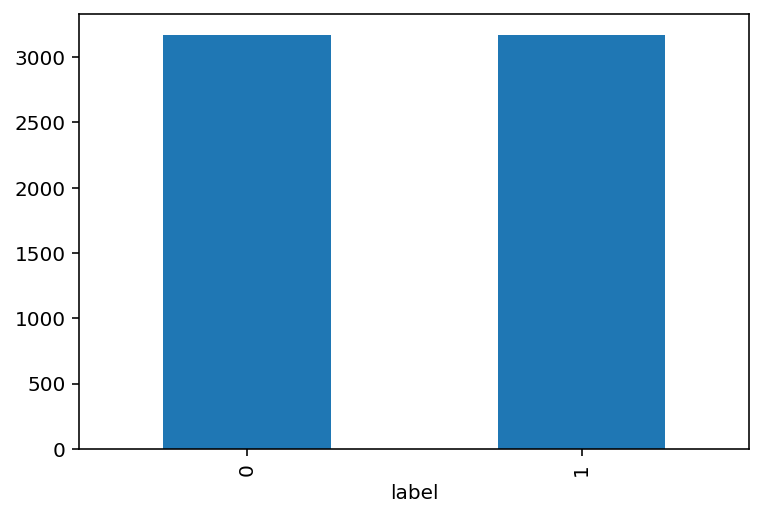

In [11]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize=(6,4))
data.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [12]:
data=data.sample(frac=1).reset_index(drop=True)

In [13]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['text'] = data['text'].apply(lambda x: ReplaceFourColon(x))

In [14]:
import re
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['text'] = data['text'].apply(lambda x: textPattern(x))

In [15]:
data.head()

,text,label
0,BY PATRICK MARTIN 5 November 2016 A New York T...,0
1,Contaminated Food from China Now Entering the ...,0
2,On this day in 1973 J Fred Buzhardt a lawyer d...,1
3,Get short URL 0 27 0 0 On Tuesday National Int...,0
4,Via Yournewswire Let the swamp draining begin ...,0


In [16]:
print(len(data))

6341


In [17]:
# data = orig_df['Text']

data['text'].head()

0    BY PATRICK MARTIN 5 November 2016 A New York T...
1    Contaminated Food from China Now Entering the ...
2    On this day in 1973 J Fred Buzhardt a lawyer d...
3    Get short URL 0 27 0 0 On Tuesday National Int...
4    Via Yournewswire Let the swamp draining begin ...
Name: text, dtype: object

In [18]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(data['text'])

In [19]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['poll', 'publish', 'document', 'disgust', 'american', 'people', 'election', 'campaign', 'alienation', 'major', 'corporate', 'control', 'party', 'margin', 'percent', 'percent', 'well', 'poll', 'say', 'campaign']


In [20]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['poll', 'publish', 'document', 'disgust', 'american', 'people', 'election', 'campaign', 'alienation', 'major', 'corporate', 'control', 'party', 'margin', 'percent', 'percent', 'well', 'poll', 'say', 'campaign']


In [21]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow


In [22]:
len(corpus)

6341

In [23]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
#                                            id2word=id2word,
#                                            num_topics=15,
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=50,
#                                            alpha="auto")

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=15,
                                           chunksize=100,
                                           workers=7, # Num. Processing Cores - 1
                                           passes=50,
                                           eval_every = 1,
                                           per_word_topics=True)

In [24]:
lda_model.save("test_model.model")

In [25]:
new_model = gensim.models.ldamodel.LdaModel.load("test_model.model")

In [26]:
train_vecs = []
for i in range(len(data)):
    top_topics = new_model.get_document_topics(corpus[i][:-1], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(15)]
    topic_vec.extend([len(data.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [27]:
train_vecs[2]

[0.009524649,
 0.009524648,
 0.009524663,
 0.009524657,
 0.009524651,
 0.009524663,
 0.00952465,
 0.8666549,
 0.0095246555,
 0.009524654,
 0.009524656,
 0.009524647,
 0.00952465,
 0.009524656,
 0.00952465,
 148]

In [28]:
# Using similar split 70/30
X = np.array(train_vecs)
y = np.array(data.label)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, data.index, test_size=0.30, random_state=100)

In [29]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
model2 = GradientBoostingClassifier(n_estimators=100, max_depth=20, random_state=32)
model2.fit(X_train_scale, y_train)
y_pred2 = model2.predict(X_test_scale)

In [31]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2)
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[669 263]
 [331 640]]
Accuracy Score : 0.6878612716763006
Report : 
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       932
           1       0.71      0.66      0.68       971

    accuracy                           0.69      1903
   macro avg       0.69      0.69      0.69      1903
weighted avg       0.69      0.69      0.69      1903



In [32]:
# test_doc = corpus[-1]

# vector = new_model[test_doc]
# print (vector)
# For topic importance
# def Sort(sub_li):
#     sub_li.sort(key = lambda x: x[1])
#     sub_li.reverse()
#     return (sub_li)
# new_vector = Sort(vector)
# print (new_vector)

## Vizualizing the Data

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.065761 -0.120395       1        1  18.561052
4     -0.119698  0.086870       2        1  11.523396
3     -0.232183 -0.062637       3        1   8.480972
10    -0.192509 -0.348722       4        1   8.227487
7      0.103401 -0.022005       5        1   7.359693
13     0.006876 -0.328231       6        1   6.683614
9      0.031673  0.328538       7        1   6.240483
6     -0.399224 -0.062677       8        1   5.903686
8      0.130712  0.187133       9        1   4.995607
2     -0.331275  0.174916      10        1   4.918304
1     -0.150382  0.340460      11        1   4.541093
0      0.221514 -0.392483      12        1   4.321803
11     0.290451 -0.166399      13        1   4.291870
14     0.414986  0.076709      14        1   2.062892
12     0.291419  0.308922      15        1   1.888048, topic_info=        Term          Freq         Total Category  logprob  loglift
32        be  26909.000000  26909.000000  Default  30.0000  30.0000
178     have   8069.000000   8069.000000  Default  29.0000  29.0000
119       do   9082.000000   9082.000000  Default  28.0000  28.0000
349      say  20344.000000  20344.000000  Default  27.0000  27.0000
372    state   6527.000000   6527.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
175     grow     82.469406    658.922363  Topic15  -5.8118   1.8914
1587    team     83.265288    785.113355  Topic15  -5.8022   1.7258
385   system     92.254778   1876.795722  Topic15  -5.6997   0.9569
1980    body     73.997296    640.043763  Topic15  -5.9202   1.8121
2034  energy     71.820125    550.411663  Topic15  -5.9501   1.9331

[1139 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
3695       1  0.184024         abortion
3695      10  0.585971         abortion
3695      13  0.045199         abortion
3695      14  0.184024         abortion
15178      6  0.982365  absentee_ballot
...      ...       ...              ...
441       12  0.029359             year
441       13  0.179953             year
10238     13  0.952380              yen
8766      10  0.914439          zionist
8766      12  0.068097          zionist

[3250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 4, 11, 8, 14, 10, 7, 9, 3, 2, 1, 12, 15, 13])

/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
